In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [2]:
sns.set(style="whitegrid")

print("--- 1. Loading Libraries and Data ---")

# Load the dataset
# The dataset is known to use '?' for missing values.
file_path = 'heart_disease_uci.csv'

if not os.path.exists(file_path):
    print(f"Error: File not found at {file_path}")
    print("Please make sure 'heart_disease_uci.csv' is in the same directory.")
else:
    df = pd.read_csv(file_path, na_values='?')
    print("Dataset loaded successfully.")
    print(df.head())
    print("\nData Info:")
    df.info()

--- 1. Loading Libraries and Data ---
Dataset loaded successfully.
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1

In [5]:
 print("\n--- 2. Data Cleaning and Preparation ---")

 # Drop irrelevant columns
 df = df.drop(columns=['id', 'dataset'])

 # Check for missing values
print("\nMissing values before imputation:")
print(df.isnull().sum())

 # Impute missing values
 # 'ca': Number of major vessels (numeric) -> Use median
 ca_median = df['ca'].median()
 df['ca'] = df['ca'].fillna(ca_median)

    # 'thal': Thallium stress test (categorical) -> Use mode
 thal_mode = df['thal'].mode()[0]
df['thal'] = df['thal'].fillna(thal_mode)

 print("\nMissing values after imputation:")
print(df.isnull().sum())

    # Convert boolean (TRUE/FALSE) columns to 0/1
 df['fbs'] = df['fbs'].map({True: 1, False: 0})
df['exang'] = df['exang'].map({True: 1, False: 0})

    # Convert sex column to 0/1
 df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})

    # Create binary target variable
    # num > 0 means presence of heart disease (1)
    # num == 0 means absence (0)
 df['target'] = (df['num'] > 0).astype(int)
 df = df.drop(columns=['num'])

 print("\nData types after cleaning:")
 df.info()
print("\nCleaned Data Head:")
print(df.head())



--- 2. Data Cleaning and Preparation ---

Missing values before imputation:
age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

Missing values after imputation:
age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca            0
thal          0
num           0
dtype: int64

Data types after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    int64  
 2   cp        920 non-null    object 
 3   trestbps  861 non-null    float64
 4   chol      890 non-null    float64
 5   fbs 


--- 3. Exploratory Data Analysis (EDA) ---
Generating plots... Close each plot window to proceed.
Saved target_distribution.png
Saved age_distribution.png
Saved chest_pain_vs_target.png
Saved sex_vs_target.png
Saved correlation_heatmap.png


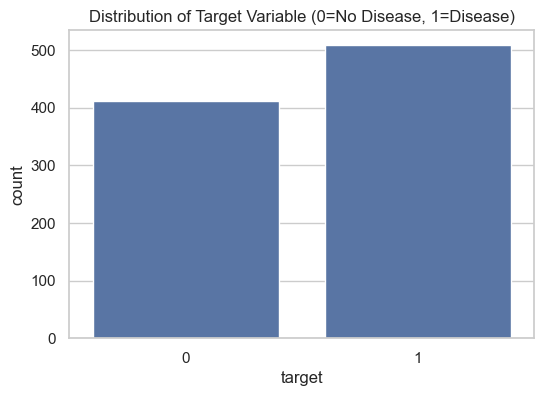

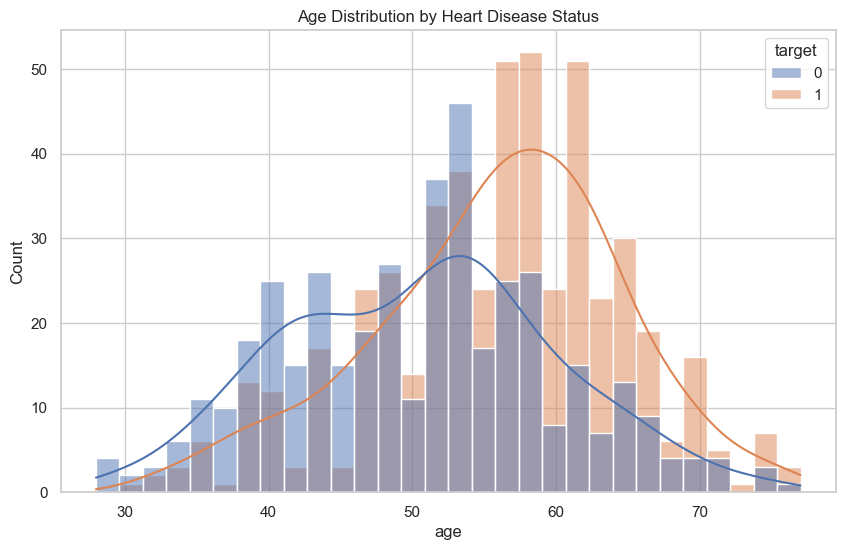

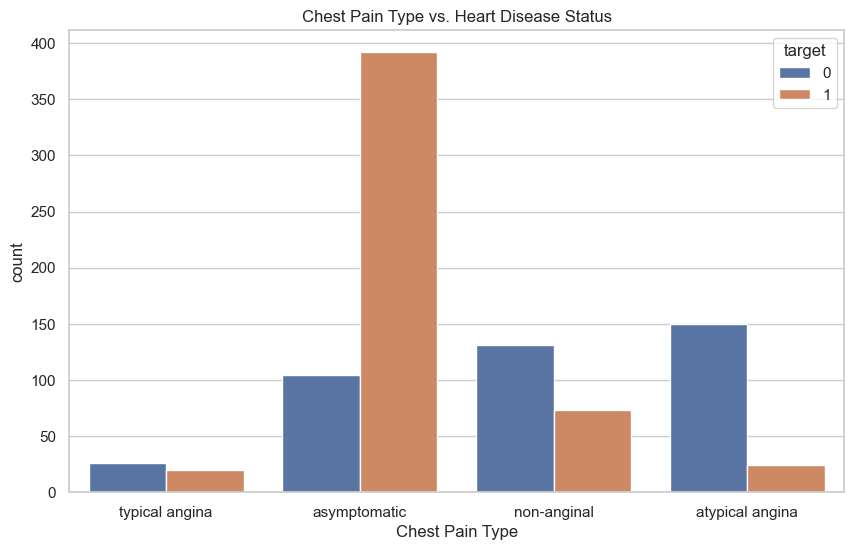

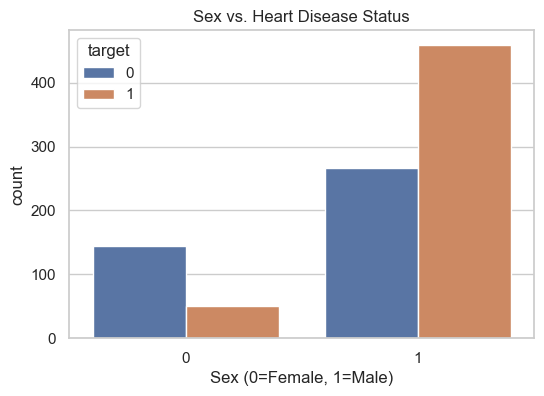

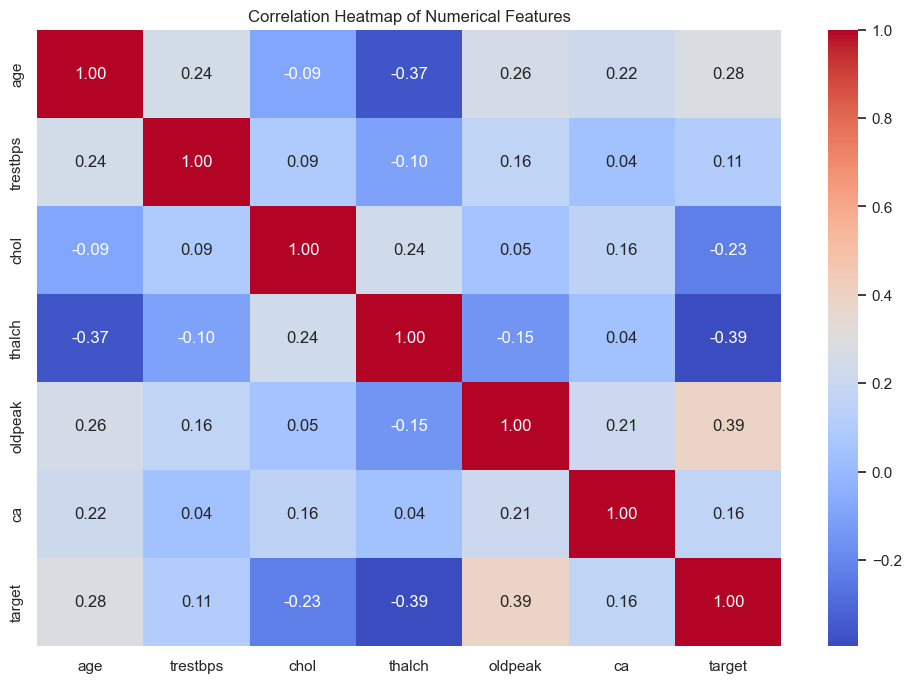

In [11]:
print("\n--- 3. Exploratory Data Analysis (EDA) ---")
print("Generating plots... Close each plot window to proceed.")

    # Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Variable (0=No Disease, 1=Disease)')
plt.savefig('target_distribution.png')
print("Saved target_distribution.png")
    # plt.show() # Uncomment this line if you want to display plots interactively

    # Age distribution by target
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='target', kde=True, bins=30)
plt.title('Age Distribution by Heart Disease Status')
plt.savefig('age_distribution.png')
print("Saved age_distribution.png")
    # plt.show()

    # Chest Pain Type vs. Target
plt.figure(figsize=(10, 6))
sns.countplot(x='cp', data=df, hue='target')
plt.title('Chest Pain Type vs. Heart Disease Status')
plt.xlabel('Chest Pain Type')
plt.savefig('chest_pain_vs_target.png')
print("Saved chest_pain_vs_target.png")
 # plt.show()

    # Sex vs. Target
plt.figure(figsize=(6, 4))
sns.countplot(x='sex', data=df, hue='target')
plt.title('Sex vs. Heart Disease Status')
plt.xlabel('Sex (0=Female, 1=Male)')
plt.savefig('sex_vs_target.png')
print("Saved sex_vs_target.png")
    # plt.show()

    # Correlation heatmap for numerical features
numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'target']
plt.figure(figsize=(12, 8))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.savefig('correlation_heatmap.png')
print("Saved correlation_heatmap.png")
    # plt.show()


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [13]:
X = df.drop('target', axis=1)
y = df['target']

    # Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

    # Identify feature types
categorical_features = ['cp', 'restecg', 'slope', 'thal']
numerical_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
passthrough_features = ['sex', 'fbs', 'exang'] # Already 0/1

    # Create the preprocessing transformers
numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Create the column transformer
preprocessor = ColumnTransformer(
transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features),
            ('pass', 'passthrough', passthrough_features)
        ])

    # Create the full pipeline with the model
model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])

    # Train the model
print("\nTraining the model...")
model.fit(X_train, y_train)
print("Model training complete.")


    # ## 5. Model Evaluation
    
print("\n--- 5. Model Evaluation ---")

    # Make predictions
y_pred = model.predict(X_test)

    # Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

    # Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

    # Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=['No Disease (0)', 'Disease (1)'],
yticklabels=['No Disease (0)', 'Disease (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
print("Saved confusion_matrix.png")
    # plt.show()

Training set size: 736 samples
Test set size: 184 samples

Training the model...


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [14]:
print("\n--- 6. Save the Model ---")
    
model_filename = 'heart_disease_model.pkl'
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")
print("\n--- Script Finished ---")


--- 6. Save the Model ---
Model saved to heart_disease_model.pkl

--- Script Finished ---


--- 1. Loading Libraries and Data ---
Dataset loaded successfully.
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1

C:\Users\ankit\AppData\Local\Temp\ipykernel_14684\2040258595.py:69: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['fbs'] = df['fbs'].fillna(fbs_mode)
C:\Users\ankit\AppData\Local\Temp\ipykernel_14684\2040258595.py:75: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['exang'] = df['exang'].fillna(exang_mode)


Saved target_distribution.png
Saved age_distribution.png
Saved chest_pain_vs_target.png
Saved sex_vs_target.png
Saved correlation_heatmap.png

--- 4. Preprocessing and Model Training ---
Training set size: 736 samples
Test set size: 184 samples

Training the model...
Model training complete.

--- 5. Model Evaluation ---

Model Accuracy: 84.24%

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.79      0.82        82
           1       0.84      0.88      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184

Saved confusion_matrix.png

--- 6. Save the Model ---
Model saved to heart_disease_model.pkl

--- Script Finished ---


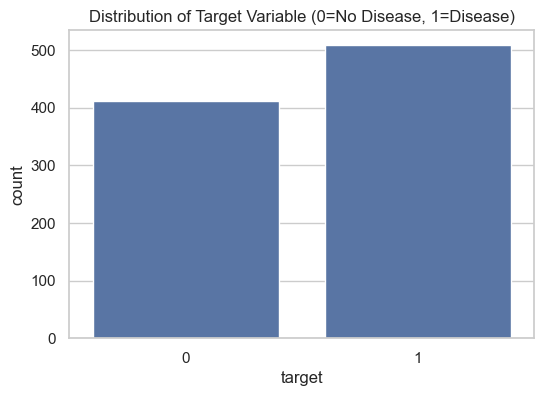

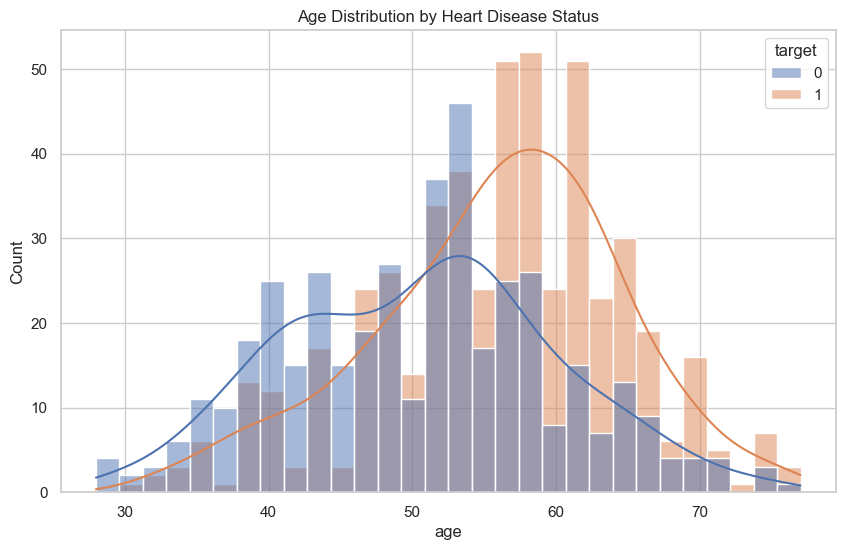

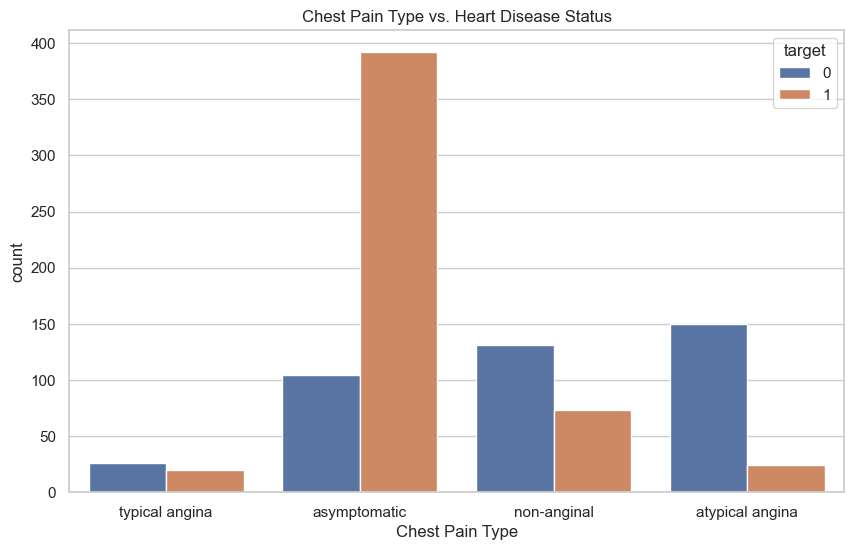

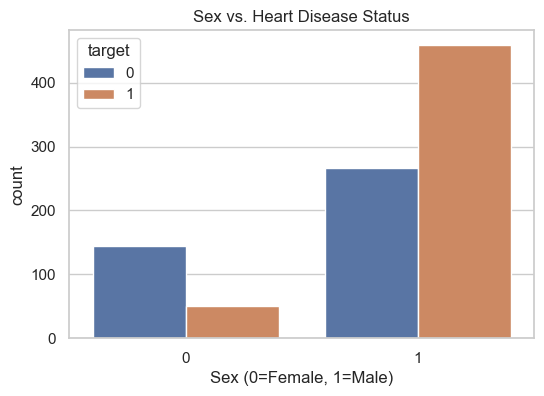

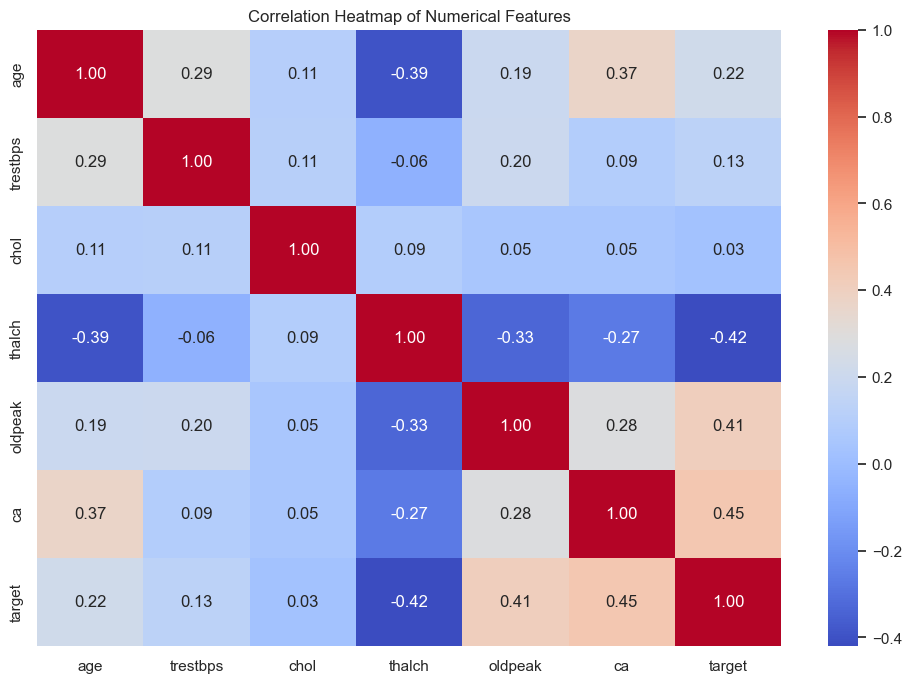

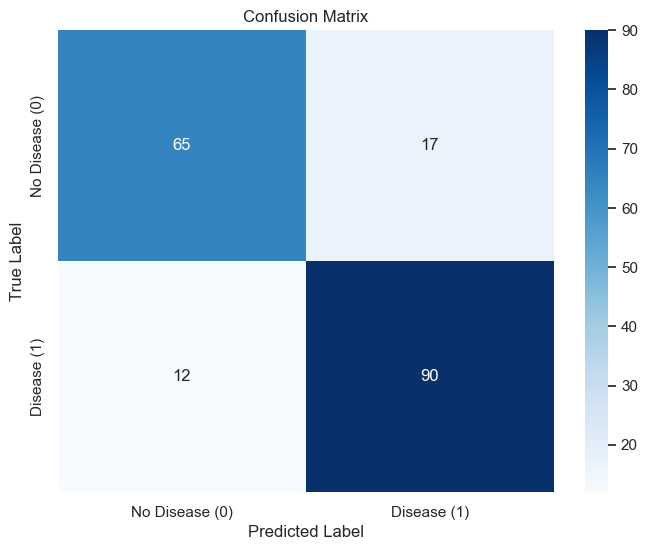

In [15]:
# Heart Disease Prediction using Logistic Regression
#
# This script walks through the process of:
# 1.  Loading and cleaning the UCI Heart Disease dataset.
# 2.  Performing Exploratory Data Analysis (EDA) with visualizations.
# 3.  Preprocessing the data for modeling.
# 4.  Training a Logistic Regression model.
# 5.  Evaluating the model and saving it for future use.

# ## 1. Load Libraries and Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Set plotting style
sns.set(style="whitegrid")

print("--- 1. Loading Libraries and Data ---")

# Load the dataset
# The dataset is known to use '?' for missing values.
file_path = 'heart_disease_uci.csv'

if not os.path.exists(file_path):
    print(f"Error: File not found at {file_path}")
    print("Please make sure 'heart_disease_uci.csv' is in the same directory.")
else:
    df = pd.read_csv(file_path, na_values='?')
    print("Dataset loaded successfully.")
    print(df.head())
    print("\nData Info:")
    df.info()

    # ## 2. Data Cleaning and Preparation
    #
    # We need to:
    # 1.  Drop irrelevant columns (`id`, `dataset`).
    # 2.  Handle missing values. We'll impute `ca` (numeric) with the median and `thal` (categorical) with the mode.
    # 3.  Convert boolean columns (`fbs`, `exang`) to integers (0 or 1).
    # 4.  Convert `sex` column to integers (0 or 1).
    # 5.  Create the binary target variable `target` (1 for heart disease, 0 for no heart disease) from the `num` column.

    print("\n--- 2. Data Cleaning and Preparation ---")

    # Drop irrelevant columns
    df = df.drop(columns=['id', 'dataset'])

    # Check for missing values
    print("\nMissing values before imputation:")
    print(df.isnull().sum())

    # Impute missing values
    # NOTE: We will impute most features inside the ML pipeline to prevent data leakage.
    # However, for columns we manually transform ('sex', 'fbs', 'exang'), 
    # we must impute them *before* transformation.
    
    # Impute 'sex' (categorical) with mode
    if df['sex'].isnull().any():
        sex_mode = df['sex'].mode()[0]
        df['sex'] = df['sex'].fillna(sex_mode)
        print(f"Imputed NaNs in 'sex' with mode: {sex_mode}")

    # Impute 'fbs' (boolean) with mode
    if df['fbs'].isnull().any():
        fbs_mode = df['fbs'].mode()[0]
        df['fbs'] = df['fbs'].fillna(fbs_mode)
        print(f"Imputed NaNs in 'fbs' with mode: {fbs_mode}")

    # Impute 'exang' (boolean) with mode
    if df['exang'].isnull().any():
        exang_mode = df['exang'].mode()[0]
        df['exang'] = df['exang'].fillna(exang_mode)
        print(f"Imputed NaNs in 'exang' with mode: {exang_mode}")

    # We are *no longer* manually imputing 'ca' and 'thal' here.
    # This will be handled by the pipeline.

    print("\nMissing values after manual imputation (sex, fbs, exang):")
    print(df.isnull().sum()) # We expect to still see NaNs in other columns

    # Convert boolean (TRUE/FALSE) columns to 0/1
    df['fbs'] = df['fbs'].map({True: 1, False: 0})
    df['exang'] = df['exang'].map({True: 1, False: 0})

    # Convert sex column to 0/1
    df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})

    # Create binary target variable
    # num > 0 means presence of heart disease (1)
    # num == 0 means absence (0)
    df['target'] = (df['num'] > 0).astype(int)
    df = df.drop(columns=['num'])

    print("\nData types after cleaning:")
    df.info()
    print("\nCleaned Data Head:")
    print(df.head())


    # ## 3. Exploratory Data Analysis (EDA)
    #
    # Let's visualize the relationships between features and the target variable.
    # Note: In a script, plt.show() will display plots one by one.
    
    print("\n--- 3. Exploratory Data Analysis (EDA) ---")
    print("Generating plots... Close each plot window to proceed.")

    # Target variable distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x='target', data=df)
    plt.title('Distribution of Target Variable (0=No Disease, 1=Disease)')
    plt.savefig('target_distribution.png')
    print("Saved target_distribution.png")
    # plt.show() # Uncomment this line if you want to display plots interactively

    # Age distribution by target
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='age', hue='target', kde=True, bins=30)
    plt.title('Age Distribution by Heart Disease Status')
    plt.savefig('age_distribution.png')
    print("Saved age_distribution.png")
    # plt.show()

    # Chest Pain Type vs. Target
    plt.figure(figsize=(10, 6))
    sns.countplot(x='cp', data=df, hue='target')
    plt.title('Chest Pain Type vs. Heart Disease Status')
    plt.xlabel('Chest Pain Type')
    plt.savefig('chest_pain_vs_target.png')
    print("Saved chest_pain_vs_target.png")
    # plt.show()

    # Sex vs. Target
    plt.figure(figsize=(6, 4))
    sns.countplot(x='sex', data=df, hue='target')
    plt.title('Sex vs. Heart Disease Status')
    plt.xlabel('Sex (0=Female, 1=Male)')
    plt.savefig('sex_vs_target.png')
    print("Saved sex_vs_target.png")
    # plt.show()

    # Correlation heatmap for numerical features
    numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'target']
    plt.figure(figsize=(12, 8))
    # We must drop NaNs *for the correlation heatmap only* since we haven't imputed them yet
    corr_matrix = df[numeric_cols].dropna().corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numerical Features')
    plt.savefig('correlation_heatmap.png')
    print("Saved correlation_heatmap.png")
    # plt.show()


    # ## 4. Preprocessing and Model Training
    #
    # We will create a full preprocessing and modeling pipeline using Scikit-learn.
    #
    # -   **Categorical features** (`cp`, `restecg`, `slope`, `thal`) will be Imputed and One-Hot Encoded.
    # -   **Numerical features** (`age`, `trestbps`, `chol`, `thalch`, `oldpeak`, `ca`) will be Imputed and Standardized.
    # -   **Binary features** (`sex`, `fbs`, `exang`) are already 0/1 and can be passed through (we imputed them manually).

    print("\n--- 4. Preprocessing and Model Training ---")
    
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    from sklearn.impute import SimpleImputer # Import the imputer

    # Define features (X) and target (y)
    X = df.drop('target', axis=1)
    y = df['target']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")

    # Identify feature types
    categorical_features = ['cp', 'restecg', 'slope', 'thal']
    numerical_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
    passthrough_features = ['sex', 'fbs', 'exang'] # Already 0/1

    # Create the preprocessing transformers
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), # Impute with median
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # Impute with mode
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Create the column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features),
            ('pass', 'passthrough', passthrough_features)
        ])

    # Create the full pipeline with the model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])

    # Train the model
    print("\nTraining the model...")
    model.fit(X_train, y_train)
    print("Model training complete.")


    # ## 5. Model Evaluation
    
    print("\n--- 5. Model Evaluation ---")

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Disease (0)', 'Disease (1)'],
                yticklabels=['No Disease (0)', 'Disease (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    print("Saved confusion_matrix.png")
    # plt.show()


    # ## 6. Save the Model
    #
    # We'll save the entire pipeline (preprocessor + model) so we can easily use it in our Streamlit app.
    
    print("\n--- 6. Save the Model ---")
    
    model_filename = 'heart_disease_model.pkl'
    joblib.dump(model, model_filename)
    print(f"Model saved to {model_filename}")
    print("\n--- Script Finished ---")

